# Burgers' Equation
## A 1+1 Dimensional Numerical Experiment of FNOs

This notebooks walks through the Fourier Neural Operator for a 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the paper [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf).

In [1]:
from ipywidgets import interact, widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop.models import FNO1d
from neuralop.datasets import load_burgers
from neuralop import count_params
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
import sys
import pprint
sys.path.insert(0, '\\'.join(sys.path[0].split('\\')[:-1]))
pprint.pprint(sys.path)


['C:\\Users\\orang\\code\\dev\\neuraloperator',
 'C:\\Users\\orang\\code\\dev\\neuraloperator\\examples',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310',
 '',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\orang\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin',
 '..',
 '.',
 '..',
 '.']


## Configuration

The following configurations control the training and evaluation of the FNO model:

In [3]:
data_filepath_input = widgets.Textarea(
    value='C:\\Users\\orang\\code\\neuraloperator\\data\\burgers_data_R10.pth',
    description='Filepath:',
    tooltip='Fully qualified file path to training/testing data.',
    disabled=False
)

# Training parameters:
n_train_input = widgets.IntText(
    value=1000,
    description='Training size:',
    tooltip='Training set size',
    disabled=False
)
n_test_input = widgets.IntText(
    value=100,
    description='Testing size:',
    tooltip='Testing set size',
    disabled=False
)
subsampling_rate_input = widgets.IntText(
    value=2**3,
    description='Subsampling rate:',
    tooltip='Subsampling rate:',
    disabled=False
)
h_input = widgets.IntText(
    value=(2**13) // subsampling_rate_input.value,
    description='H:',
    disabled=False
)
s_input = widgets.IntText(
    value=h_input.value,
    description='S:',
    disabled=False
)
batch_size_input = widgets.IntText(
    value=32,
    description='Batch size:',
    disabled=False
)
learning_rate_input = widgets.FloatText(
    value=0.001,
    description='Learning rate:',
    disabled=False
)
epochs_input = widgets.FloatText(
    value=20,
    description='Epochs:',
    disabled=False
)
iterations_input = widgets.FloatText(
    value=epochs_input.value * (n_train_input.value // batch_size_input.value),
    description='Iterations:',
    disabled=False
)
modes_input = widgets.FloatText(
    value=16,
    description='Modes count:',
    disabled=False
)
width_input = widgets.FloatText(
    value=64,
    description='Width:',
    disabled=False
)

display(data_filepath_input)
display(n_train_input)
display(n_test_input)
display(subsampling_rate_input)
display(h_input)
display(s_input)
display(batch_size_input)
display(learning_rate_input)
display(epochs_input)
display(iterations_input)
display(modes_input)
display(width_input)

Textarea(value='C:\\Users\\orang\\code\\neuraloperator\\data\\burgers_data_R10.pth', description='Filepath:', …

IntText(value=1000, description='Training size:', tooltip='Training set size')

IntText(value=100, description='Testing size:', tooltip='Testing set size')

IntText(value=8, description='Subsampling rate:', tooltip='Subsampling rate:')

IntText(value=1024, description='H:')

IntText(value=1024, description='S:')

IntText(value=32, description='Batch size:')

FloatText(value=0.001, description='Learning rate:')

FloatText(value=10.0, description='Epochs:')

FloatText(value=310.0, description='Iterations:')

FloatText(value=16.0, description='Modes count:')

FloatText(value=64.0, description='Width:')

In [4]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
# FIXME colab link: https://drive.google.com/drive/folders/1UnbQh2WWc6knEHbLn-ZaXrKUZhp7pjt-?usp=sharing
# FIXME add zenodo link or streaming (latter for colab)
train_loader, test_loader = load_burgers(
    data_filepath_input.value, 
    n_train_input.value, 
    n_test_input.value,
    batch_test=1
)

# Get the shape of outputs (for later testing) from the first testing data point
for _, y in test_loader:
    y_test_shape = y.shape

In [5]:
# FIXME model = FNO1d(modes, width, use_mlp=True, mlp_expansion=1.0).cuda()
model = FNO1d(
    # modes_height : number of Fourier modes to keep along the height
    int(modes_input.value),

    # hidden_channels : width of the FNO (i.e. number of channels)
    int(width_input.value),
    
    in_channels=2,
    use_mlp=True,
    decompostion_kwargs={'dtype', torch.cdouble},
    fno_block_precision='double',
    dtype=torch.float64,
)

In [6]:
print("Model parameter count:", count_params(model))
print(model)

Model parameter count: 312897
FNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([64, 64, 8]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    )
    (mlp): ModuleList(
      (0-3): 4 x MLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 1, kernel_size=(1,), stride=(1,))
    )
  )
)


In [11]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_input.value, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations_input.value)

loss = LpLoss()
for ep in range(int(epochs_input.value)):
    model.train()
    t1 = default_timer()
    # Mean Squared Error;
    # will be measured pointwise on predicted field function u(x, t)
    # for each discretized point (i.e. by x-value).
    train_mse = 0  
    train_l2 = 0
    for x, y in train_loader:
        # FIXME x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        # from IPython.core import debugger as ipdb; ipdb.set_trace()
        # print('x.shape=', x.shape)
        out = model(x)

        mse = mse_loss(
            out.view(batch_size_input.value, -1),
            y.view(batch_size_input.value, -1), 
            reduction='mean'
        )
        l2 = loss(
            out.view(batch_size_input.value, -1),
            y.view(batch_size_input.value, -1)
        )
        l2.backward() # use the l2 relative loss

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # FIXME x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += loss(
                out.view(batch_size_input.value, -1),
                y.view(batch_size_input.value, -1)
            ).item()

    train_mse /= len(train_loader)
    train_l2 /= n_train_input.value
    test_l2 /= n_test_input.value

    t2 = default_timer()
    print(
        f'Epoch # {ep}',
        f'Duration:     {t2-t1:9.5f}',
        f'Training MSE: {train_mse:9.5f}',
        f'Training L2:  {train_l2:9.5f}',
        f'Testing L2:   {test_l2:9.5f}',
        '=' * 32,
        sep='\n',
    )

Epoch # 0
Duration:      32.66292
Training MSE:   0.00206
Training L2:    0.07703
Testing L2:     2.15096
Epoch # 1
Duration:      34.55830
Training MSE:   0.00018
Training L2:    0.03113
Testing L2:     1.63485
Epoch # 2
Duration:      32.42625
Training MSE:   0.00012
Training L2:    0.02581
Testing L2:     1.62641
Epoch # 3
Duration:      31.57399
Training MSE:   0.00011
Training L2:    0.02389
Testing L2:     1.38830
Epoch # 4
Duration:      32.69845
Training MSE:   0.00008
Training L2:    0.02111
Testing L2:     1.23056
Epoch # 5
Duration:      31.79896
Training MSE:   0.00007
Training L2:    0.01940
Testing L2:     1.14220
Epoch # 6
Duration:      30.07474
Training MSE:   0.00006
Training L2:    0.01733
Testing L2:     1.07133
Epoch # 7
Duration:      29.52180
Training MSE:   0.00005
Training L2:    0.01613
Testing L2:     1.03132
Epoch # 8
Duration:      30.30093
Training MSE:   0.00005
Training L2:    0.01563
Testing L2:     1.01007
Epoch # 9
Duration:      31.17392
Training MSE

In [9]:
pred = torch.zeros(len(test_loader), *(y_test_shape[1:]))
index = 0

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        test_l2 = 0
        # FIXME x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out.view(-1)

        test_l2 += loss(out.view(1, -1), y.view(1, -1)).item()
        # print(index, test_l2)
        index = index + 1

C:\Users\orang\AppData\Local\Temp\ipykernel_21880\3206791453.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


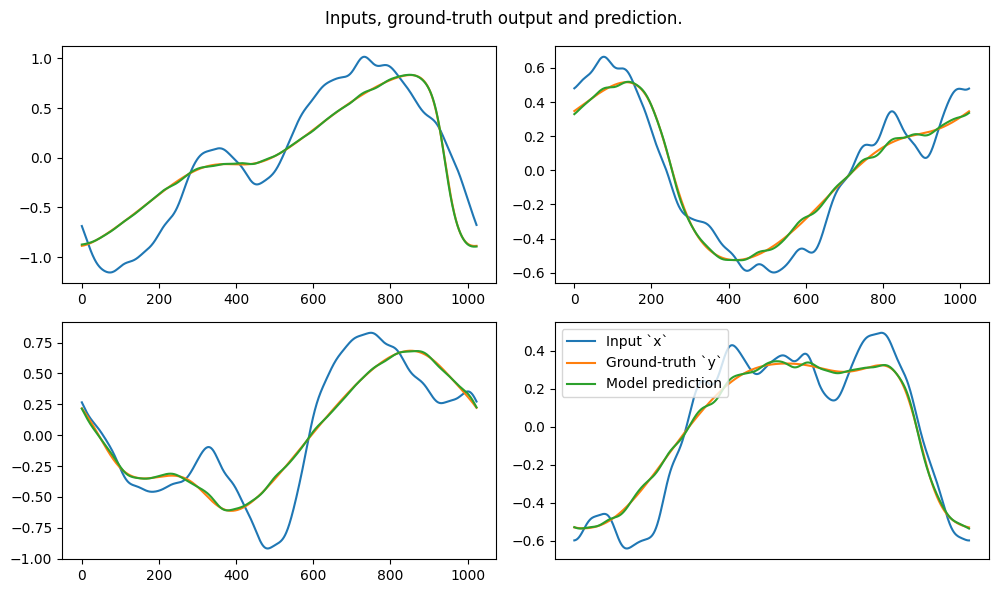

In [10]:
import matplotlib.pyplot as plt
test_samples = test_loader.dataset

fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
for index, ax in enumerate(axs.flat):
    data = test_samples[index * 20]
    # Input ``a`` & Ground-truth ``u``
    a, u = data
    # Model prediction
    out = model(a.unsqueeze(0))
    ax.plot(a[0], label="Input `x`")
    ax.plot(u.squeeze(), label="Ground-truth `y`")
    ax.plot(out.squeeze().detach().numpy(), label="Model prediction")
    plt.xticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.legend(loc='upper left')

We can barely see the Ground Truth curve above, so the model's prediction already aggrees with the solver to within a small error. Moreover, this is only within 20 epochs of training. Real-world applications would be trained for much longer - on the order of 500 epochs.